In [220]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (9,6) 
plt.rcParams["font.family"] = "sans-serif"

from matplotlib.pyplot import figure
import matplotlib.cm as cm

# figure(figsize=(20, 16), dpi=160)

plt.style.use('ggplot')
cmap = cm.get_cmap('Blues')

import numpy as np

#### Load Data

In [221]:
# single gpu

# stopping
gpu1_1e14_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e14_stopping_training_data.csv')
gpu1_1e15_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e15_stopping_training_data.csv')
gpu1_1e16_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e16_stopping_training_data.csv')

# no stopping
gpu1_1e14 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e14_training_data.csv')
gpu1_1e15 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e15_training_data.csv')
gpu1_1e16 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e16_training_data.csv')

# four gpu

# stopping
gpu4_1e14_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e14_stopping_training_data.csv')
gpu4_1e15_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e15_stopping_training_data.csv')
gpu4_1e16_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e16_stopping_training_data.csv')

# no stopping
gpu4_1e14 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e14_training_data.csv')
gpu4_1e15 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e15_training_data.csv')
gpu4_1e16 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e16_training_data.csv')


## Epoch Savings

For epoch savings, the number of GPUs should be (?) irrelevant, so we just use the different GPUs as repeated tests. It doesn't seem to be irrelevant, though. We should look into that. Is it just random? Should do more tests to find out.

In [222]:
import math
num_epochs_without_stopping = len(gpu1_1e14.index)

num_epochs_with_stopping_1e14 = [len(gpu1_1e14_stopping.index), len(gpu4_1e14_stopping.index)]
num_epochs_with_stopping_1e15 = [len(gpu1_1e15_stopping.index), len(gpu4_1e15_stopping.index)]
num_epochs_with_stopping_1e16 = [len(gpu1_1e16_stopping.index), len(gpu4_1e16_stopping.index)]

avg_epochs_completed_1e14 = sum(num_epochs_with_stopping_1e14)/len(num_epochs_with_stopping_1e14)
avg_epochs_completed_1e15 = sum(num_epochs_with_stopping_1e15)/len(num_epochs_with_stopping_1e15)
avg_epochs_completed_1e16 = sum(num_epochs_with_stopping_1e16)/len(num_epochs_with_stopping_1e16)

print("Avg. epochs completed for 1e14:", avg_epochs_completed_1e14)
print("Avg. epochs completed for 1e15:", avg_epochs_completed_1e15)
print("Avg. epochs completed for 1e16:", avg_epochs_completed_1e16)

percent_epochs_saved_1e14 = 1-(avg_epochs_completed_1e14/num_epochs_without_stopping)
percent_epochs_saved_1e15 = 1-(avg_epochs_completed_1e15/num_epochs_without_stopping)
percent_epochs_saved_1e16 = 1-(avg_epochs_completed_1e16/num_epochs_without_stopping)

print("Avg. percent epochs saved for 1e14:", percent_epochs_saved_1e14*100)
print("Avg. percent epochs saved for 1e15:", percent_epochs_saved_1e15*100)
print("Avg. percent epochs saved for 1e16:", percent_epochs_saved_1e16*100)



Avg. epochs completed for 1e14: 2134.0
Avg. epochs completed for 1e15: 1573.0
Avg. epochs completed for 1e16: 1688.0
Avg. percent epochs saved for 1e14: 14.639999999999997
Avg. percent epochs saved for 1e15: 37.08
Avg. percent epochs saved for 1e16: 32.48


[[0.57960784 0.77019608 0.87372549 1.        ]
 [0.23192618 0.54565167 0.76261438 1.        ]
 [0.03137255 0.28973472 0.57031911 1.        ]]
Baseline (2500, 2500, 2500)
1GPU (2167, 1647, 1737)
4GPU (2101, 1499, 1639)


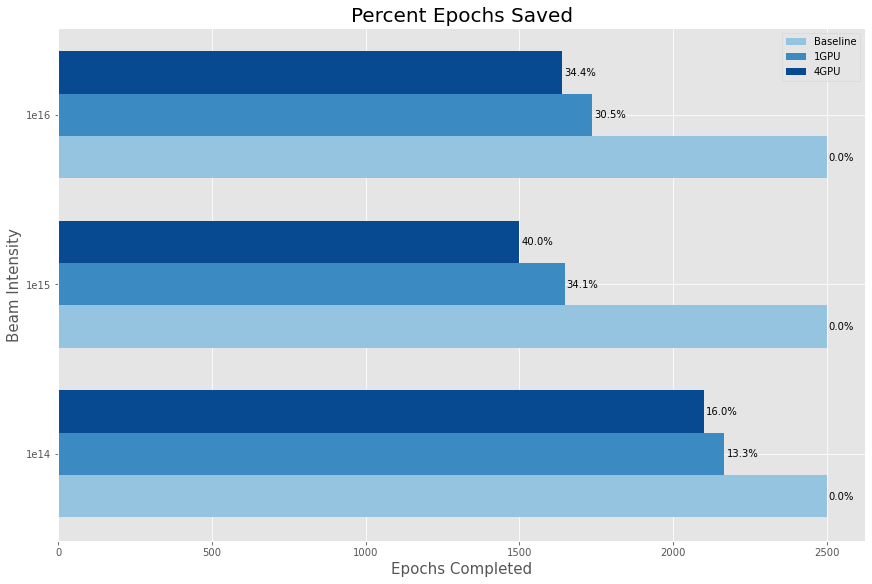

In [237]:



width = 0.2
multiplier = 0

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

beam_intensity = ("1e14", "1e15", "1e16")
epochs_run = {
    'Baseline': (num_epochs_without_stopping, num_epochs_without_stopping, num_epochs_without_stopping),
    '1GPU': (len(gpu1_1e14_stopping.index), len(gpu1_1e15_stopping.index), len(gpu1_1e16_stopping.index)),
    '4GPU': (len(gpu4_1e14_stopping.index), len(gpu4_1e15_stopping.index), len(gpu4_1e16_stopping.index)),
}

x = np.arange(len(beam_intensity))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
colors = cmap(np.linspace(0.4, 0.9, 3))
print(colors)

for index, (label, num_epochs) in enumerate(epochs_run.items()):
    print(label, num_epochs)
    offset = width * multiplier
    rects = ax.barh(x + offset, num_epochs, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
    labels = [str(round((1-(num_epochs[i]/num_epochs_without_stopping))*100, 1))+'%' for i in range(len(num_epochs))]
    ax.bar_label(rects, labels=labels ,padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Epochs Completed', fontsize=15)
ax.set_ylabel('Beam Intensity', fontsize=15)

ax.set_title('Percent Epochs Saved', fontsize=20)
ax.set_yticks(x + width, beam_intensity)
ax.legend(loc='upper right')
# ax.set_ylim(0, 2500)

plt.show()


## Time Savings

Below is making and saving the time file (by hand, unfortuantely). This will be made automatic in subsequent runs.

In [224]:
from datetime import datetime, timedelta

def get_run_time(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time

def get_run_seconds(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time.total_seconds()

gpu=[1,1,1,1,1,1,4,4,4,4,4,4]
stopping=[False, False, False, True, True, True, False, False, False, True, True, True]
dataset=['14','15','16','14','15','16','14','15','16','14','15','16']
time=['2-02_01_42','2-03_52_23','2-00_38_20','1-22_33_04','1-12_05_38','1-08_18_16','0-14_32_18','0-14_54_32','0-13_53_12','0-12_03_46','0-09_10_05','0-09_27_38']

time_df = pd.DataFrame()
time_df['gpu'] = gpu
time_df['dataset'] = dataset
time_df['stopping'] = stopping
time_df['time'] = time
time_df['total_time'] = time_df['time'].apply(get_run_time)
time_df['total_seconds'] = time_df['time'].apply(get_run_seconds)
time_df.to_csv('./icpp_training_results/time_to_run.csv', index=False)

### Now we look at time savings

Need to think about how to graph this, though

In [225]:
time_df = pd.read_csv('./icpp_training_results/time_to_run.csv')
time_df.head()

,gpu,dataset,stopping,time,total_time,total_seconds
0,1,14,False,2-02_01_42,2 days 02:01:42,180102.0
1,1,15,False,2-03_52_23,2 days 03:52:23,186743.0
2,1,16,False,2-00_38_20,2 days 00:38:20,175100.0
3,1,14,True,1-22_33_04,1 days 22:33:04,167584.0
4,1,15,True,1-12_05_38,1 days 12:05:38,129938.0


1GPU without Stopping (50.028333333333336, 51.87305555555555, 48.638888888888886)
1GPU with Stopping (46.55111111111111, 36.09388888888889, 32.30444444444444)
4GPU without Stopping (14.538333333333334, 14.908888888888889, 13.886666666666667)
4GPU with Stopping (12.062777777777777, 9.168055555555556, 9.460555555555555)


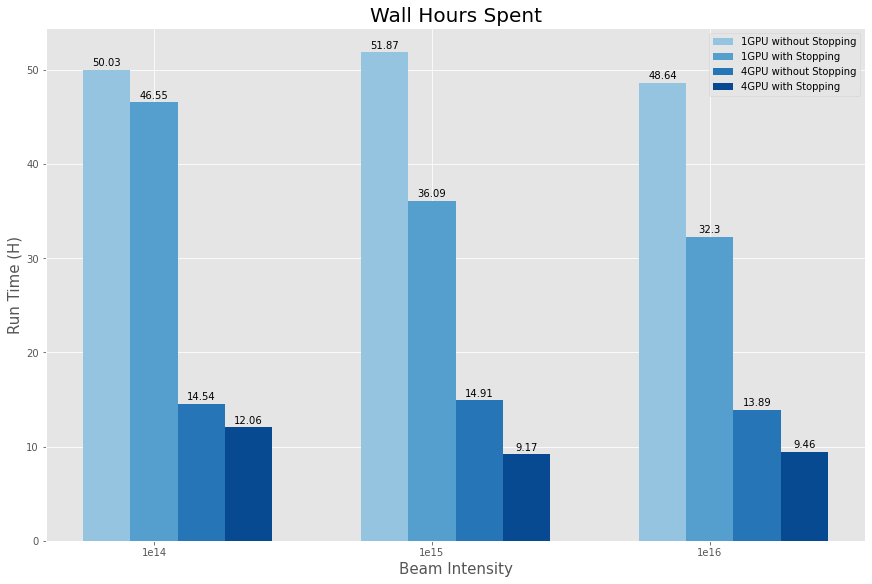

In [236]:

## prepping data
time_format='total_seconds'
e14_time = time_df[(time_df['dataset']==14)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600
e15_time = time_df[(time_df['dataset']==15)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600
e16_time = time_df[(time_df['dataset']==16)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600

e14_time_stopping = time_df[(time_df['dataset']==14)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600
e15_time_stopping = time_df[(time_df['dataset']==15)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600
e16_time_stopping = time_df[(time_df['dataset']==16)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600

gpu4_e14_time = time_df[(time_df['dataset']==14)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e15_time = time_df[(time_df['dataset']==15)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e16_time = time_df[(time_df['dataset']==16)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600

gpu4_e14_time_stopping = time_df[(time_df['dataset']==14)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e15_time_stopping = time_df[(time_df['dataset']==15)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e16_time_stopping = time_df[(time_df['dataset']==16)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

beam_intensity = ("1e14", "1e15", "1e16")
epochs_run = {
    '1GPU without Stopping': (e14_time, e15_time, e16_time),
    '1GPU with Stopping': (e14_time_stopping, e15_time_stopping, e16_time_stopping),
    '4GPU without Stopping': (gpu4_e14_time, gpu4_e15_time, gpu4_e16_time),
    '4GPU with Stopping': (gpu4_e14_time_stopping, gpu4_e15_time_stopping, gpu4_e16_time_stopping),
}

x = np.arange(len(beam_intensity))  # the label locations
width = 0.17  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
colors = cmap(np.linspace(0.4, 0.9, 4))

for index, (label, times) in enumerate(epochs_run.items()):
    print(label, times)
    offset = width * multiplier
    rects = ax.bar(x + offset, times, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
    labels = [round(time, 2) for time in times]
    ax.bar_label(rects, labels=labels ,padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Run Time (H)', fontsize=15)
ax.set_xlabel('Beam Intensity', fontsize=15)

ax.set_title('Wall Hours Spent', fontsize=20)
ax.set_xticks(x + width, beam_intensity)
ax.legend(loc='upper right')
# ax.set_ylim(0, 2500)

plt.show()